# TM10007 Assignment template

In [98]:
# Run this to use from colab environment
!git clone https://github.com/Doesjka/TM10007_ML_g9.git

fatal: destination path 'TM10007_ML_g9' already exists and is not an empty directory.


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [99]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
import seaborn
import matplotlib.pyplot as plt

data = pd.read_csv('/content/TM10007_ML_g9/worclipo/Lipo_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 115
The number of columns: 494


## Splitting data in train and test set


In [123]:
# X = data.reset_index(drop=True)
y = data['label']
X = data.drop('label', axis=1)
# print(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# print(X_train)



ID
Lipo-012_0    1
Lipo-073_0    1
Lipo-030_0    1
Lipo-042_0    1
Lipo-100_0    1
             ..
Lipo-091_0    1
Lipo-049_0    1
Lipo-057_0    0
Lipo-052_0    0
Lipo-006_0    0
Name: label, Length: 86, dtype: object


## Handling missing data 
### Throwing out features
All features that exist of at least 50% zeros are deleted from the data. 


In [101]:
zeros = (X_train == 0).sum()
threshold = 0.5 * len(y_train)
print('Threshold = ', threshold)
feature_del = zeros[zeros > threshold]

X_train = X_train.drop(columns=feature_del.index)
print(f'{len(data.columns)-len(X_train.columns)} features were deleted')

Threshold =  43.0
25 features were deleted


In [102]:
more_zeros = (X_train == 0).sum()
columns_zeros = more_zeros[more_zeros > 0].index
print(f'Of the remaining features, {len(columns_zeros)} features have at least one zero')
print(f'There is a total of {more_zeros.sum()} zeros left in the data')


Of the remaining features, 10 features have at least one zero
There is a total of 44 zeros left in the data


## Calculate number of missing values per sample

In [103]:
zeros_r = (X_train == 0).sum(axis=1)
threshold = 0.005 * X_train.size / len(y_train)
print('Threshold = ', threshold)
feature_del = zeros_r[zeros_r > threshold]
print(feature_del)

Threshold =  2.345
ID
Lipo-090_0    5
Lipo-095_0    3
Lipo-076_0    3
Lipo-003_0    3
dtype: int64


In [104]:
from scipy.stats import shapiro

aantal_normaal = 0

for column in X_train.columns:
    result = shapiro(X_train[column])
    # print(result.pvalue)
    normaal = result.pvalue > 0.05
    aantal_normaal += normaal
    
print(aantal_normaal)



74


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Filling remaining zeros
All remaining zeros are replaced by the mean of that feature. 

In [105]:
X_train_mean = X_train
X_train_median = X_train

for column in columns_zeros[:]:
    print('Kolom: ', column)
    column_mean = X_train.loc[X_train[column]!=0, column].mean()
    column_median = X_train.loc[X_train[column]!=0, column].median()
    print('mean = ', column_mean)
    print('median = ', column_median)

    verschil2_percolumn = column_mean - column_median
    print('Verschil tussen mean en median = ',verschil2_percolumn)

    # result = shapiro(X_train[column])
    # result.pvalue
    print('p-waarde normaalverdeling = ', shapiro(X_train.loc[X_train[column]!=0, column]).pvalue)

    X_train_mean[column].replace(0, column_mean)
    X_train_median[column].replace(0, column_median)

    print(' ')

verschil = abs(X_train_mean - X_train_median)
print('Totaal verschil = ', verschil.sum().sum())

# X_train.head()
# pd.set_option('display.max_rows', None)
# print(X_train[columns_zeros[0]])
# pd.set_option('display.max_rows', 10)


Kolom:  PREDICT_original_sf_area_min_2.5D
mean =  456.8698899846219
median =  200.39520811289555
Verschil tussen mean en median =  256.4746818717264
p-waarde normaalverdeling =  3.05788068477586e-11
 
Kolom:  PREDICT_original_tf_LBP_quartile_range_R8_P24
mean =  9.301204819277109
median =  11.0
Verschil tussen mean en median =  -1.6987951807228914
p-waarde normaalverdeling =  1.931198130478151e-05
 
Kolom:  PREDICT_original_vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  2.766293780856362e-07
median =  4.602205232532876e-10
Verschil tussen mean en median =  2.7616915756238295e-07
p-waarde normaalverdeling =  9.707482768662333e-20
 
Kolom:  PREDICT_original_vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  2.766293780856362e-07
median =  4.602205232532876e-10
Verschil tussen mean en median =  2.7616915756238295e-07
p-waarde normaalverdeling =  9.707482768662333e-20
 
Kolom:  PREDICT_original_vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  8.705055316112096e-

## Scaling

In [106]:
scaler = preprocessing.StandardScaler().fit(X_train_median)
X_train_scaled = scaler.transform(X_train_median)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_median.columns)

# scaler = preprocessing.RobustScaler().fit(X_train_median)
# X_train_scaled = scaler.transform(X_train_median)
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_median.columns)

# scaler = preprocessing.MinMaxScaler().fit(X_train_median)
# X_train_scaled = scaler.transform(X_train_median)
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_median.columns)

## PCA

gewoon pca  [92.87270314 80.77665325 37.84606127 25.9898159 ]
gewoon pca  [0.19911668 0.17318306 0.08114098 0.05572149]
linear   [7894.17976701 6866.01552589 3216.91520815 2209.13435126 1955.04683909]
linear  [0.19911668 0.17318306 0.08114098 0.05572149 0.04931259]
poly  2   [37.1914877  34.21361227 16.11666205 13.95065131 12.45740918]
poly  2   [0.13603039 0.12513861 0.05894779 0.05102545 0.04556382]
poly  3   [77.47397114 71.57947073 46.16845565 37.30044601 33.62244678]
poly  3   [0.10387591 0.09597266 0.06190196 0.05001187 0.04508046]
poly  4   [194.33267203 162.53395129 149.9310336  122.07048222  91.87596384]
poly  4   [0.09659659 0.08079046 0.07452595 0.06067735 0.04566862]
rbf   [5.47657182 4.22755147 3.52115195 2.79948207 2.13759713]
rbf  [0.08039681 0.06206103 0.05169099 0.04109678 0.03138021]


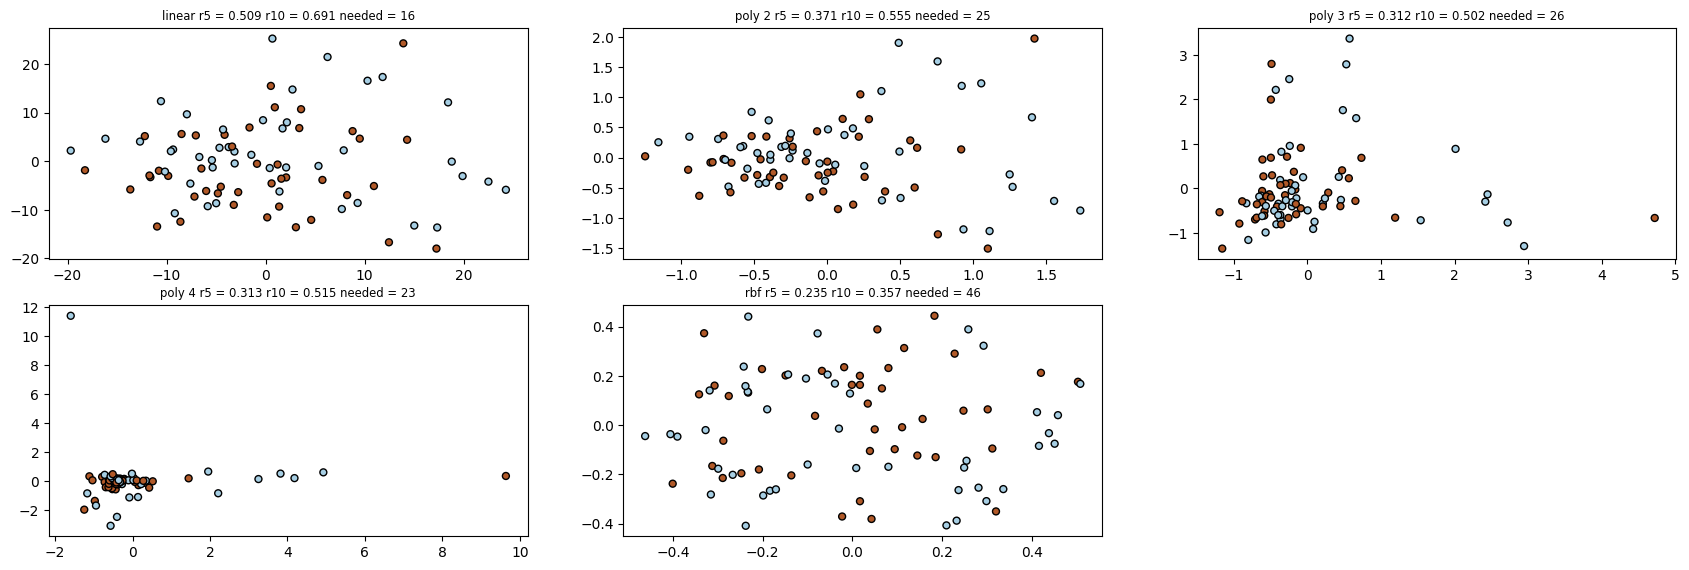

In [173]:
pca = decomposition.PCA()
pca.fit(X_train_scaled_df)
X_pca = pca.transform(X_train_scaled_df)
print("gewoon pca ", pca.explained_variance_[0:4])
print("gewoon pca ", pca.explained_variance_ratio_[0:4])

kernels = ['linear', 'poly', 'rbf']#, 'sigmoid', 'cosine']#, 'precomputed'] 

fig = plt.figure(figsize=(21,7*len(kernels)))
num=0 

degrees = [2, 3, 4]

y_train.values[y_train.values == 'lipoma'] = 0
y_train.values[y_train.values == 'liposarcoma'] = 1

for kernel in kernels:
    if kernel == 'poly':
        for degree in degrees:
            pca = decomposition.KernelPCA(kernel=kernel,degree=degree)
            pca.fit(X_train_scaled_df)
            X_pca = pca.transform(X_train_scaled_df)
            ax = fig.add_subplot(6, 3, num + 1)
            ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y_train,
               s=25, edgecolor='k', cmap=plt.cm.Paired)
            
            print(kernel + " ", str(degree), " ", pca.eigenvalues_[0:5])

            explained_variance_ratios = pca.eigenvalues_ / pca.eigenvalues_.sum()

            print(kernel + " ", str(degree), " ", explained_variance_ratios[0:5])

            
            total_ratio = 0
            i=0
            while total_ratio < 0.8:
                total_ratio += explained_variance_ratios[i]
                i+=1

            ax.set_title(kernel + " " + str(degree) + " " +
                         "r5 = " + str(round(explained_variance_ratios[0:4].sum(),3))+ " "  +
                         "r10 = " + str(round(explained_variance_ratios[0:9].sum(),3))+ " "  +
                    "needed = " + str(i),
             fontsize='small')
            num+=1
    else:
        pca = decomposition.KernelPCA(kernel=kernel)
        pca.fit(X_train_scaled_df)
        X_pca = pca.transform(X_train_scaled_df)
        ax = fig.add_subplot(6, 3, num + 1)
        ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y_train,
               s=25, edgecolor='k', cmap=plt.cm.Paired)
        
        print(kernel, " ", pca.eigenvalues_[0:5])

        explained_variance_ratios = pca.eigenvalues_ / pca.eigenvalues_.sum()

        print(kernel + " ", explained_variance_ratios[0:5])

        i=0
        total_ratio = 0
        while total_ratio < 0.8:
            total_ratio += explained_variance_ratios[i]
            i+=1

        ax.set_title(kernel + " " + 
            	    "r5 = " + str(round(explained_variance_ratios[0:4].sum(),3))+ " "  +
                    "r10 = " + str(round(explained_variance_ratios[0:9].sum(),3))+ " "  +
                    "needed = " + str(i),
             fontsize='small')

        num+=1


# print(round(pca.eigenvalues_.sum(),3))

# X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)


# seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)

# plt.xscale('log')
# plt.yscale('log')
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
# print(sum(pca.explained_variance_ratio_))

# pca_df = pd.DataFrame(pca.components_,columns=X_train_scaled_df.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5'])
# max_feature = pca_df.idxmax(axis=1)
# print(X_train_scaled_df[max_feature.iloc[1]])
# seaborn.scatterplot(x=X_train_scaled_df[max_feature.iloc[0]], y=X_train_scaled_df[max_feature.iloc[1]], hue=labels_train)
# print(max_feature)